# YOLO

### Preparing data

In [20]:
ls Datasets


classes.csv  train_01.zip  validation-annotations-bbox.csv
doodles/     validation/


In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

from matplotlib.collections import PatchCollection

from data_aug.data_aug import *
from data_aug.bbox_util import *
import cv2 
import pickle as pkl
from IPython.display import display, HTML


In [22]:
df = pd.read_csv("Datasets/validation-annotations-bbox.csv")

In [23]:
#df.head()

In [24]:
classes_df = pd.read_csv("Datasets/classes.csv", names= ['LabelName','Class'])
#classes_df.head()

In [25]:
df = pd.merge(df,classes_df,how = 'inner')
df = df.sort_values(by=['ImageID'])

### Selecting just persons class

In [26]:
df = df[((df['Class']=='Boy') | (df['Class']=='Man' ) | (df['Class']=='Girl' ) | (df['Class']=='Woman' ))]

In [27]:
# Number of samples
df['Class'].value_counts().sum()

17977

In [28]:
df.sample()

ImageID  Source LabelName  Confidence     XMin      XMax  \
8282  f90ead55fbc3327d  xclick  /m/04yx4           1  0.11828  0.305376   

          YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
8282  0.236364  0.854545           1            0          0            0   

      IsInside Class  
8282         0   Man

### Class for processing data

In [29]:
class ImageGenerator():
    def __init__(self, df, path):
        self.df = df
        self.path = path
        
    def plot_image(self, image_id):
        
        # Load image
        path = 'Datasets/validation/'
        img = mpimg.imread(path+image_id+'.jpg')
        
        # Load boxes points
        boxes = self.df[self.df['ImageID'] == image_id]
        boxes_data = pd.DataFrame({
            'xmin' : boxes['XMin'].values,
            'xmax' : boxes['XMax'].values,
            'ymin' : boxes['YMin'].values,
            'ymax' : boxes['YMax'].values
        })
        
        # Preparing data for plot
        
        boxes_data['xmin'] *= img.shape[1]
        boxes_data['xmax'] *= img.shape[1]
        boxes_data['ymin'] *= img.shape[0]
        boxes_data['ymax'] *= img.shape[0]
        boxes_data['xcenter'] = boxes_data['xmin'] + (boxes_data['xmax']-boxes_data['xmin'])/2
        boxes_data['ycenter'] = boxes_data['ymin'] + (boxes_data['ymax']-boxes_data['ymin'])/2
        boxes_data['width'] = boxes_data['xmax']-boxes_data['xmin']
        boxes_data['height'] = boxes_data['ymax']-boxes_data['ymin']
        
        # Create Rectangles
        plot_boxes = []
        
        for i in boxes_data.index:
            rec = patches.Rectangle(
                                (boxes_data['xmin'][i],boxes_data['ymin'][i]),
                                boxes_data['width'][i],
                                boxes_data['height'][i],
                                fill = False
            )
            plot_boxes.append(rec)
            
        
        pc = PatchCollection(plot_boxes, match_original=True) # Join rectangles
        
        # Plot
        
        plt.imshow(img)

        ax = plt.gca()
        ax.add_collection(pc)
        plt.show()
        
    def get_boxes(self, image_id, new_size):
        
        # Load boxes points
        boxes = self.df[self.df['ImageID'] == image_id]
        boxes_data = pd.DataFrame({
            'xmin' : boxes['XMin'].values,
            'ymin' : boxes['YMin'].values,
            'xmax' : boxes['XMax'].values,
            'ymax' : boxes['YMax'].values
        })
        
        # Preparing data for plot
        
        boxes_data['xmin'] *= new_size[0]
        boxes_data['xmax'] *= new_size[0]
        boxes_data['ymin'] *= new_size[1]
        boxes_data['ymax'] *= new_size[1]
        
        
        return(boxes_data)
    
    
    def generate_output_format(self, image_id, augmentation = True, size = (700,700), output_size = (26, 26), anchors = 3):
        
        # Modify agumentation (HERE)
        seq = Sequence([RandomHSV(18, 18, 30),RandomHorizontalFlip(), RandomScale(), RandomTranslate(), RandomRotate(10), RandomShear()])
        
        
        img = cv2.imread(self.path + '/' + image_id + '.jpg')[:,:,::-1]
        img = cv2.resize(img,size)
        
        #boxes_df = self.get_boxes(image_id, size)
        boxes = self.get_boxes(image_id, size).to_numpy()
        
        if augmentation == True:
            try:
                #print("Try")
                img, boxes = seq(img, boxes.copy())
            except:
                pass
                #print("Could not convert data to an integer.")
        
        
        # Create new image data frame
        boxes_df = pd.DataFrame(data=boxes,  columns=['xmin','ymin','xmax','ymax'])
        boxes_df['xcenter'] = boxes_df['xmin'] + (boxes_df['xmax']-boxes_df['xmin'])/2
        boxes_df['ycenter'] = boxes_df['ymin'] + (boxes_df['ymax']-boxes_df['ymin'])/2
        
        
        out_put = np.zeros((output_size[0],output_size[1],anchors * 5))
        x_ratio = size[0]/output_size[0]
        y_ratio = size[1]/output_size[1]
        intervals_x = np.arange(start=0, stop=output_size[0], step=1) * x_ratio
        intervals_y = np.arange(start=0, stop=output_size[1], step=1) * y_ratio
        
        
        
        #Ubicate points in row
        def get_index(row):
            x_i = np.argwhere((intervals_x  <= row['xcenter']) & ((intervals_x+x_ratio)  >= row['xcenter']) )[0][0]
            y_i = np.argwhere((intervals_y  <= row['ycenter']) & ((intervals_y+y_ratio)  >= row['ycenter']) )[0][0]
            
            cx = (row['xcenter']-intervals_x[x_i])/x_ratio
            cy = (row['ycenter']-intervals_y[y_i])/y_ratio
            
            width = (row['xmax']-row['xmin'])/size[0]
            height = (row['ymax']-row['ymin'])/size[1]
            
            return(x_i, y_i, cx, cy, width, height)
        
        """
        #Plot rectangles
        
        plotted_img = draw_rect(img, boxes)
        plt.imshow(plotted_img)
        plt.show()
        
        """
        
        # Array with marks in the center of image
        #marks_out = np.zeros(output_size)
        
        # Here is the shape of the outputs  
        out = np.zeros((output_size[0],output_size[1],5))
        
        
        image_out_df = boxes_df.apply(get_index, axis = 1,result_type="expand")
        image_out_df.columns=['x_i', 'y_i', 'cx', 'cy', 'width', 'height']
        image_out_df["class"] = 1
        image_out_df = image_out_df.drop_duplicates(subset=['x_i', 'y_i'], keep='first')
        
        
        y_i = image_out_df['y_i'].values.astype(int)
        x_i = image_out_df['x_i'].values.astype(int)
        """
        #Plot Marks
        
        marks_out[(y_i,x_i)]=255
        plt.imshow(marks_out)
        plt.show()
        
        """
        
        
        out[(y_i,x_i)]=image_out_df[['class', 'cx', 'cy', 'width', 'height']].to_numpy()
        
        #display(HTML(image_out_df.to_html()))
        #print(len(image_out_df.index))
        return(img, out)

In [30]:
ig = ImageGenerator(df, "Datasets/validation")

# Create TF Model

In [31]:
in_size = (700, 700, 3)

In [32]:
inputs = tf.keras.Input(in_size)

x = tf.keras.layers.Conv2D(20, kernel_size = (3,3), activation = "relu")(inputs)
x = tf.keras.layers.MaxPool2D(pool_size =(2,2))(x)
x = tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = "relu")(x)
x = tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = "relu")(x)
x = tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = "relu")(x)
x = tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = "relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size =(2,2))(x)
x = tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = "relu")(x)
x = tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = "relu")(x)
x = tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = "relu")(x)
x = tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = "relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size =(2,2))(x)
x = tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation = "relu")(x)
x = tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = "relu")(x)
x = tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = "relu")(x)
x = tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = "relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size =(2,2))(x)
x = tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = "relu")(x)
x = tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = "relu")(x)
x = tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = "relu")(x)
x = tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = "relu")(x)
x = tf.keras.layers.Conv2D(5, kernel_size = (3,3), activation = "sigmoid")(x)

model = tf.keras.Model(inputs=inputs,outputs=x)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 700, 700, 3)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 698, 698, 20)      560       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 349, 349, 20)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 347, 347, 32)      5792      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 345, 345, 32)      9248      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 343, 343, 32)      9248      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 341, 341, 32)      9248

In [33]:
@tf.function
def custom_loss(y_true, y_pred):
    cross_entropy_box = -(y_true * tf.math.log(y_pred) + (1-y_true) * tf.math.log(1 -y_pred)) * tf.expand_dims(y_true[:,:,:,0], axis=-1)
    cross_entropy_person = -(153 * y_true[:,:,:,0] * tf.math.log(y_pred[:,:,:,0]) + (1-y_true[:,:,:,0]) * tf.math.log(1 -y_pred[:,:,:,0]))/153
    
    
    #m = cross_entropy.shape[0]
    #print(cross_entropy)
    #print(cross_entropy_box.shape)
    #print(cross_entropy_person.shape)
    #print(cross_entropy_person[0,0,0])
    #print(tf.reduce_sum(cross_entropy).numpy())
    
    final_loss = (tf.reduce_sum(cross_entropy_box,[1,2,3]))/(5) + (tf.reduce_sum(cross_entropy_person,[1,2]))/(1)
    #final_loss = (tf.reduce_sum(cross_entropy_person,[1,2]))/(1)
    
    return(final_loss)

In [34]:
model.compile(optimizer="adam",
              loss = custom_loss,
              metrics = ['accuracy'])

In [35]:
12.3**2

151.29000000000002

In [36]:
26*26/4.4

153.63636363636363

In [37]:
#Create validation data
val_in = []
val_out = []
for i in df.sample(10)['ImageID'].values:
    val_in_new, val_out_new = ig.generate_output_format(i,augmentation=False)
    val_in.append(val_in_new/255)
    val_out.append(val_out_new)
val_in = np.array(val_in)
val_out = np.array(val_out)


#batch 100
#epochs 30
batch = 20
epochs = 1
data = []


In [39]:

print("it will train {} times".format(int(17977*epochs/batch)))


for j in range(2500):#range(int(17977*epochs/batch)):
    print(j)
    train_in = []
    train_out = []
    for i in df.sample(batch)['ImageID'].values:
        train_in_new, train_out_new = ig.generate_output_format(i,augmentation=False)
        train_in.append(train_in_new/255)
        train_out.append(train_out_new)
    train_in = np.array(train_in)
    train_out = np.array(train_out)
    data.append(model.fit(train_in, train_out, validation_data=(val_in,val_out)))

it will train 898 times
0
1/1 [==============================] - 2s 2s/step - loss: 11.6306 - accuracy: 1.0000 - val_loss: 14.6821 - val_accuracy: 1.0000
1
1/1 [==============================] - 2s 2s/step - loss: 9.4764 - accuracy: 1.0000 - val_loss: 15.2949 - val_accuracy: 1.0000
2
1/1 [==============================] - 2s 2s/step - loss: 13.5149 - accuracy: 1.0000 - val_loss: 15.6116 - val_accuracy: 1.0000
3
1/1 [==============================] - 2s 2s/step - loss: 11.8513 - accuracy: 1.0000 - val_loss: 15.6504 - val_accuracy: 1.0000
4
1/1 [==============================] - 2s 2s/step - loss: 13.9587 - accuracy: 1.0000 - val_loss: 15.3322 - val_accuracy: 1.0000
5
1/1 [==============================] - 2s 2s/step - loss: 7.8359 - accuracy: 1.0000 - val_loss: 15.3132 - val_accuracy: 1.0000
6
1/1 [==============================] - 2s 2s/step - loss: 13.7670 - accuracy: 1.0000 - val_loss: 14.9092 - val_accuracy: 1.0000
7
1/1 [==============================] - 2s 2s/step - loss: 9.2007 -

KeyboardInterrupt: 

In [ ]:
95 90 100

In [45]:
pr_in = []
pr_out = []
names = []
for i in df.sample(50)['ImageID'].values:
    names.append(i)
    pr_in_new, pr_out_new = ig.generate_output_format(i,augmentation=False)
    pr_in.append(pr_in_new/255)
    pr_out.append(pr_out_new)
pr_in = np.array(pr_in)
pr_out = np.array(pr_out)
pr = model.predict(pr_in)

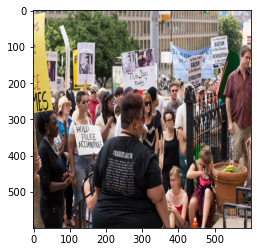

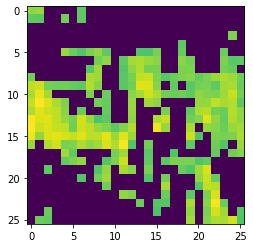

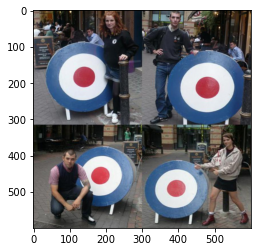

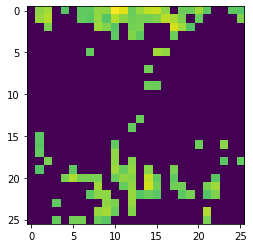

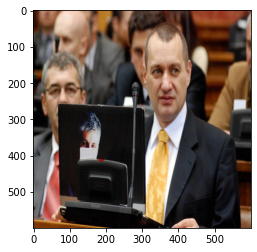

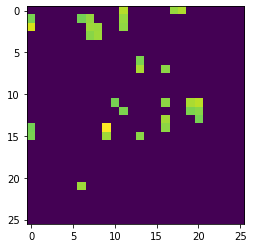

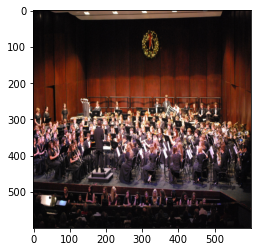

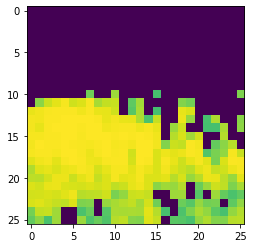

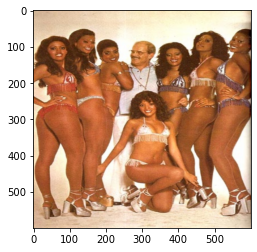

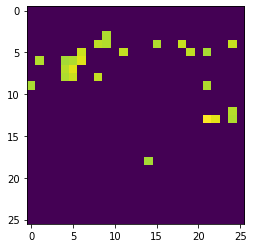

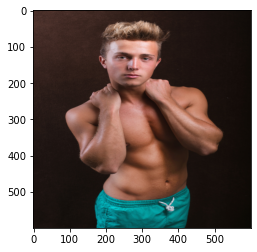

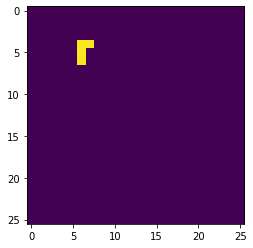

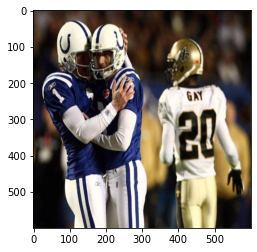

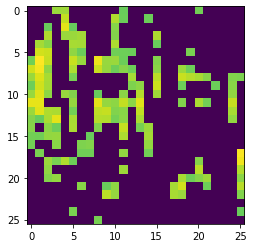

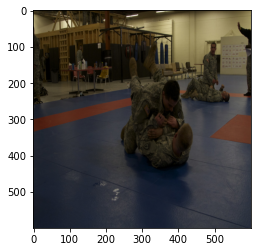

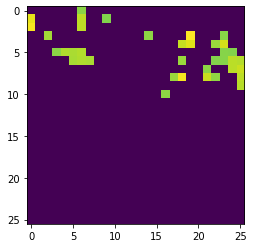

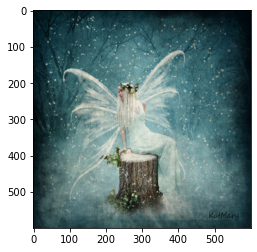

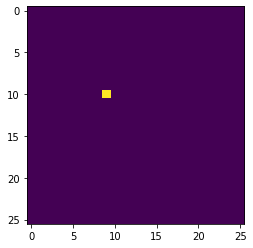

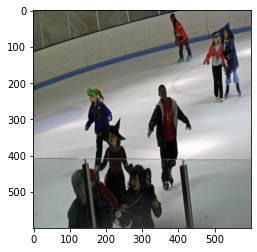

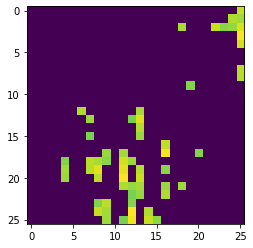

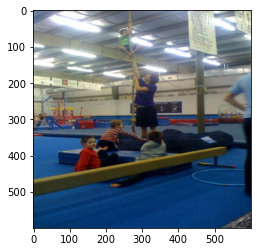

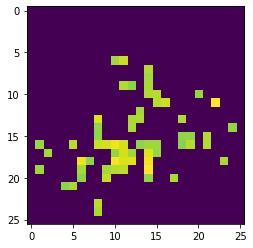

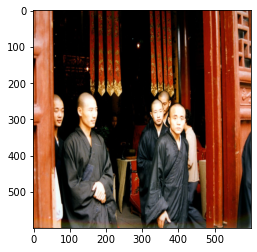

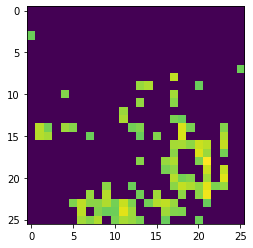

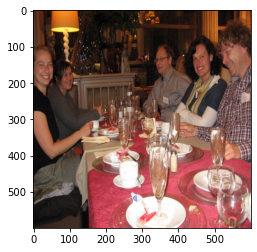

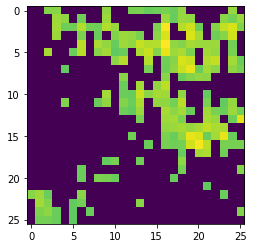

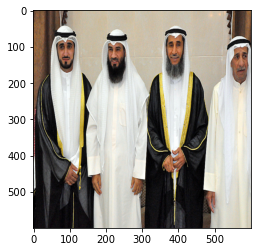

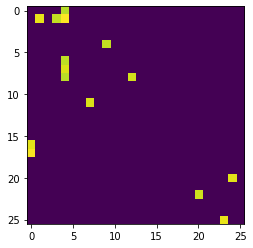

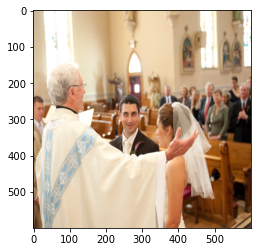

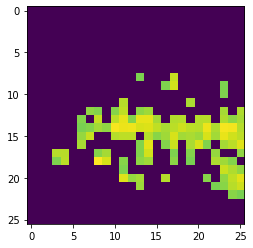

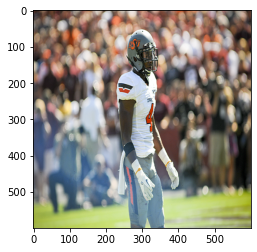

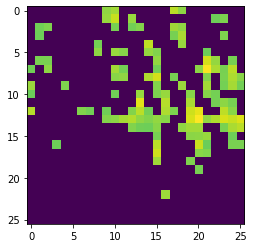

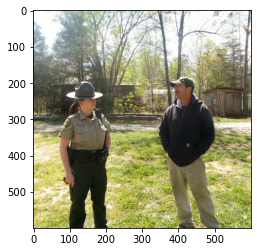

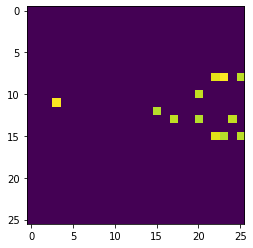

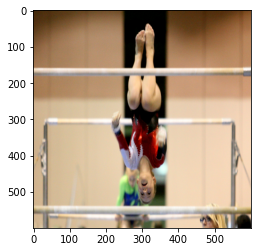

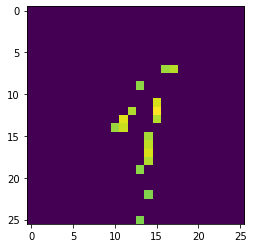

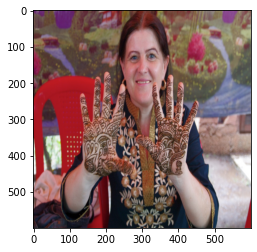

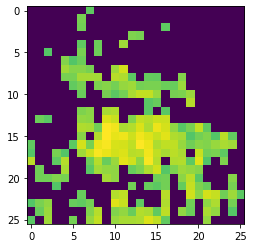

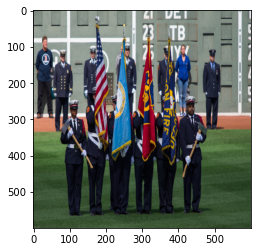

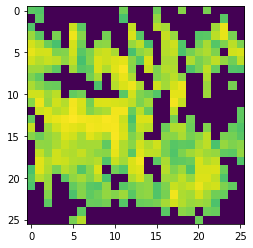

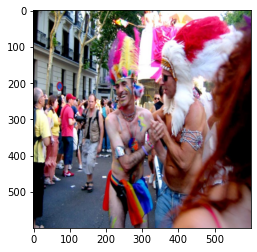

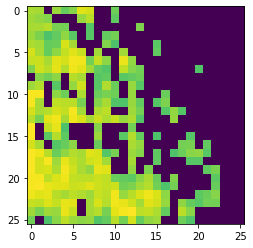

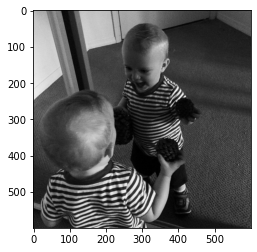

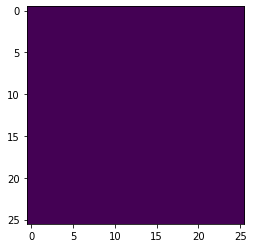

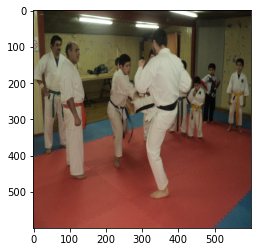

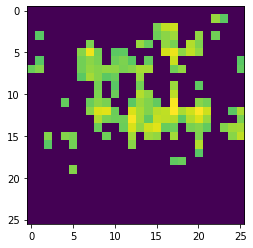

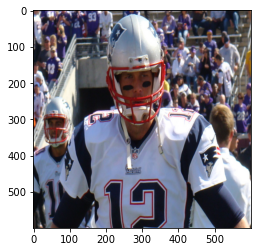

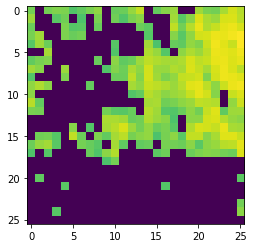

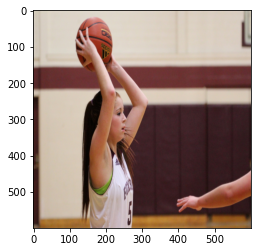

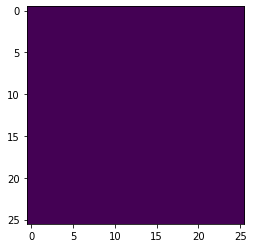

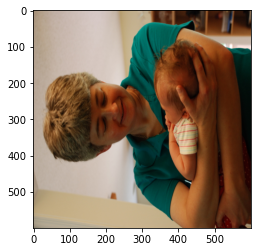

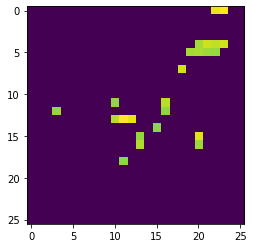

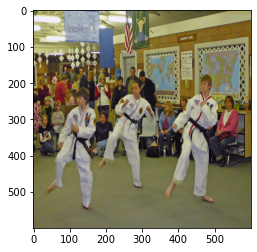

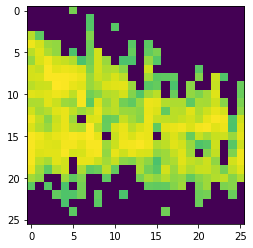

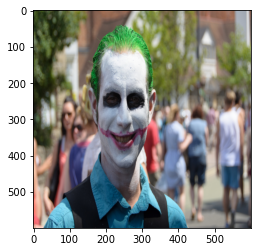

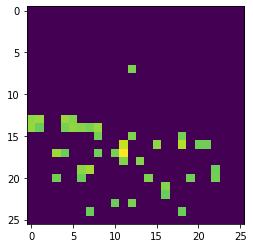

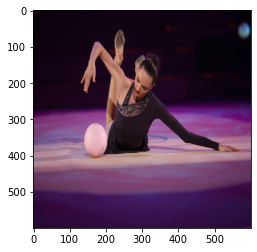

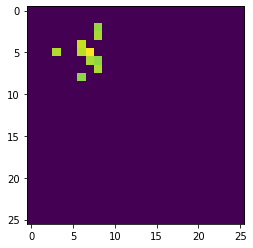

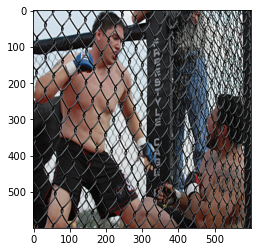

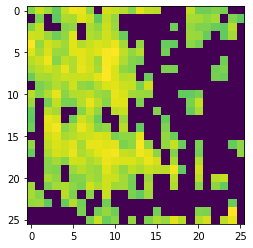

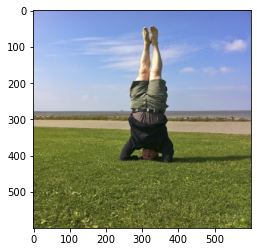

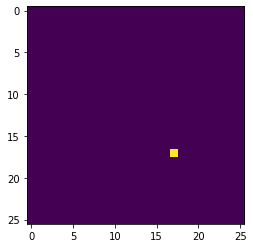

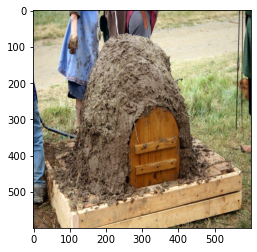

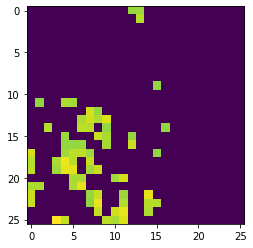

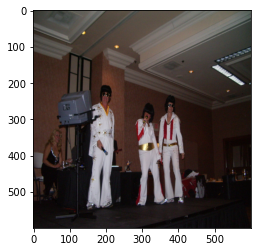

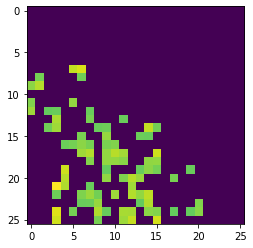

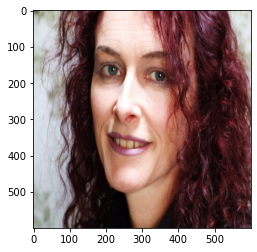

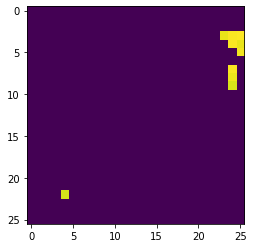

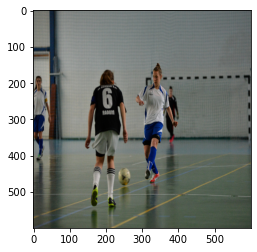

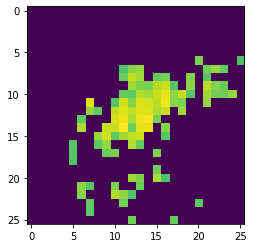

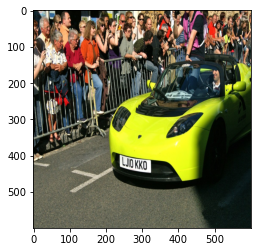

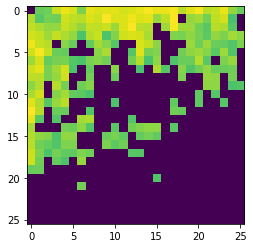

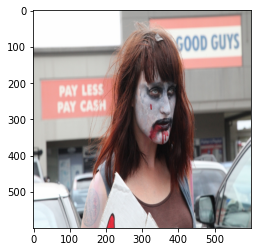

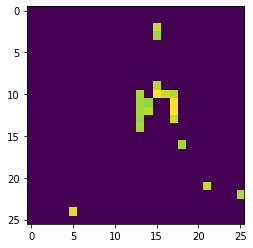

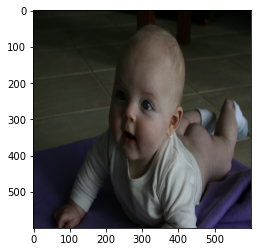

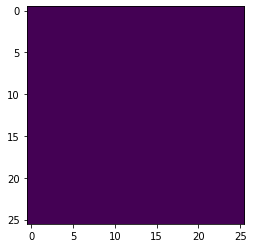

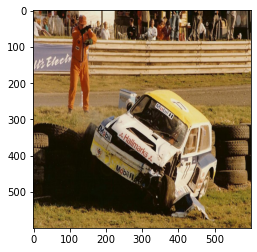

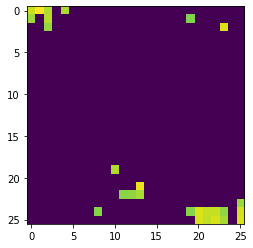

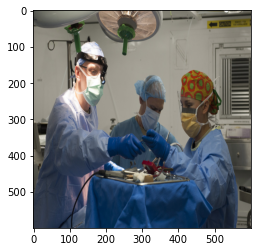

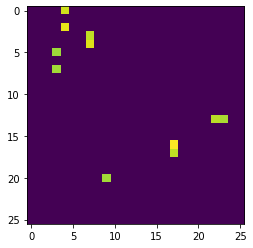

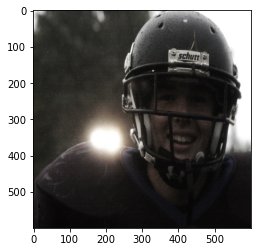

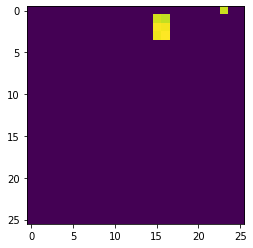

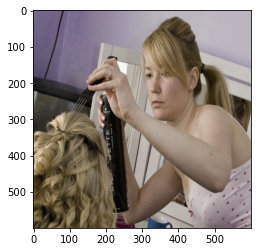

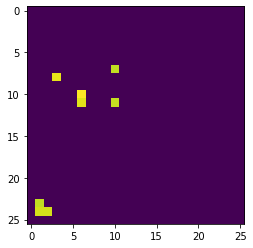

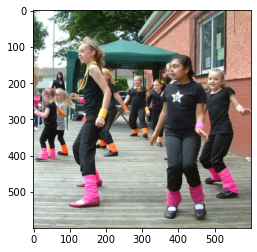

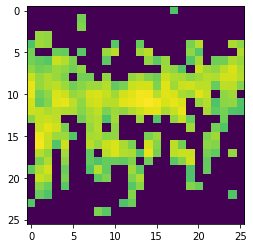

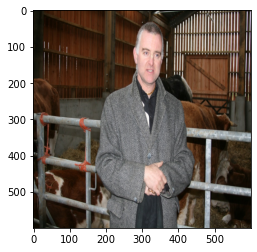

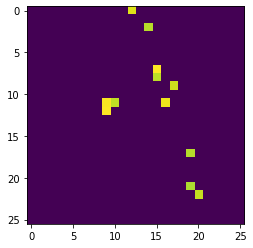

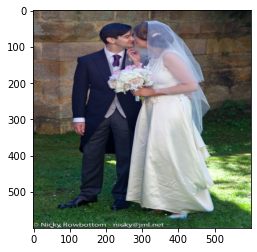

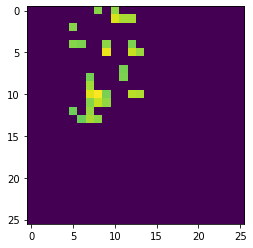

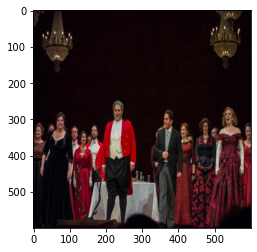

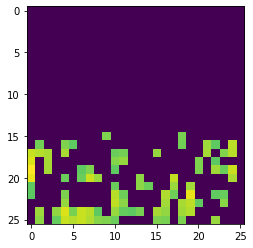

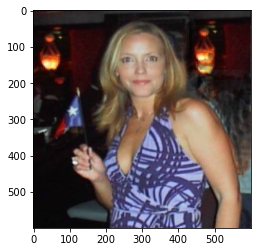

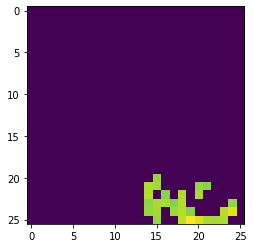

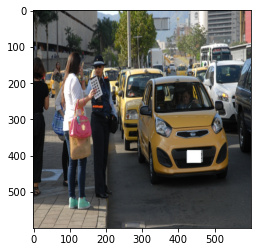

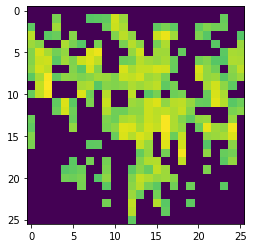

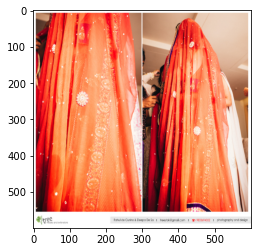

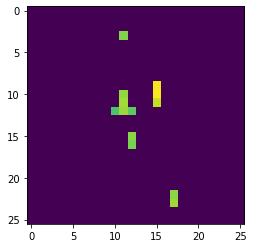

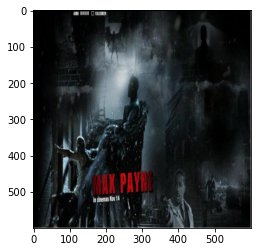

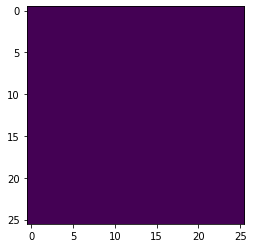

In [46]:
for i in range(len(pr)):
    image_id = '7092b10448a58362'
    img = cv2.imread('Datasets/validation/' + names[i] + '.jpg')[:,:,::-1]
    img = cv2.resize(img,(600,600))
    plt.imshow(img)
    plt.show()
    plt.imshow((pr[i][:,:,0])*(pr[i][:,:,0]>.7)*255)
    plt.show()

In [ ]:
pr[0][:,:,0]

In [ ]:
pr[1][:,:,0]

In [47]:
model.save('yolo_test1') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: yolo_test1/assets


In [48]:
ls

data_aug/  Datasets/  Multi_layer_perceptron.ipynb  Yolo.ipynb  yolo_test1/


In [50]:
ls y*

assets/  saved_model.pb  variables/
